# Behavior based classification

In this notebook, we evaluate the classification performance of different behavioral features on predicting drug, drug-dose, and drug class.

Wiltschko et al. 2022 demonstrated that their behavioral syllable featurization outperformed "scalar" behavioral features.
They posited that the "time-series modeling approach used by MoSeq captures more relevant behavioral variance than simply aggregating behavioral data into histograms (as done by the scalar behavioral summary)."

We further test this hypothesis and suggest that the additional compositional time-series modeling that DTD captures even more relevant behavioral variance than the syllable-usage frequencies that Wiltschko et al.

We compare the following three behavioral featurizations:
- Aggregated syllable usage (i.e. Wiltschko et al)
- Topic usage weights of a Latent Dirichlet Allocation model
- Session usage weights of a DTD model

In [1]:
from collections import OrderedDict

from jax import lax, vmap
import jax.numpy as jnp
import numpy as onp

from tqdm.notebook import trange

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelBinarizer
from scipy.spatial.distance import pdist, squareform

import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

from dtd.data import load_wiltschko22_data


## Load data

In [2]:
DATASET_DIR = "/home/groups/swl1/eyz/data/moseq-drugs/"

In [3]:
data = OrderedDict()

**Syllable usages, aggregated by session**

We can sum over all bins of the binned data to reconstruct the Wiltschko et al. "moseq fingerprints."

In [4]:
filepath = DATASET_DIR + "syllable_binned_1min.npz"
X, batch_axes, event_axes, metadata = load_wiltschko22_data(filepath)

data['sum'] = X.sum(axis=1) / (X.sum(axis=1)).sum(axis=-1, keepdims=True)
print(f"{data['sum'].shape=}")  # (n_sessions, n_syllables)

data['sum'].shape=(500, 90)


**LDA**

In [14]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda_30 = LDA(n_components=30)  # same number of topics as in DTD
lda_30_weights = lda_30.fit_transform(X.reshape(500, -1))
print(lda_30_weights.shape)
data['lda_30'] = lda_30_weights

(500, 30)

In [16]:
lda_20 = LDA(n_components=20)  # same number of session factors as in DTD
lda_20_weights = lda_20.fit_transform(X.reshape(500, -1))

print(lda_20_weights.shape)
data['lda_20'] = lda_20_weights

(500, 20)


**DTD session weights**

In [5]:
# TODO Save to fixed file, e.g. in Model similarity analysis notebook
run_path = "/scratch/users/eyz/moseq-dtd-fit-20250130/jlwvmomm/"  # jlwvmomm: highest lp, wj155x4a: lowest lp

with onp.load(run_path+'params.npz') as f:

    n_sessions = len(f['F1'])

    data['dtd_f1'] = f['F1']  # session weights only

    dynamic_topic_weights = onp.einsum(
        "ijk, di, tj -> dtk", f['G'], f['F1'], f['F2']
    )
    data['dtd_gf1f2'] = dynamic_topic_weights.reshape(n_sessions, -1)

print(f"{data['dtd_f1'].shape=}")  # (n_sessions, n_session_factors)  # F1: 0.57 +/- 0.05
print(f"{data['dtd_gf1f2'].shape=}")  # (n_sessions, n_bins*n_topics)  # F1: 

data['dtd_f1'].shape=(500, 20)
data['dtd_gf1f2'].shape=(500, 600)


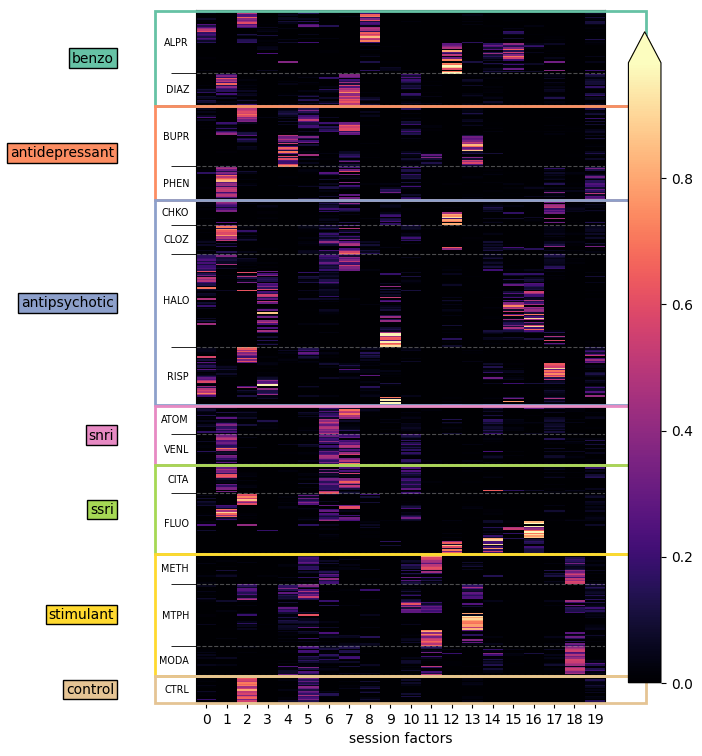

In [6]:
from dtd.viz import draw_drug_class_boxes, set_syllable_cluster_ticks

plt.figure(figsize=(6,9))
im = plt.imshow(data['dtd_f1'], aspect='auto', interpolation='none', cmap='magma', vmin=0)
plt.yticks([])
plt.xticks(range(20))
plt.xlabel('session factors')


draw_drug_class_boxes(metadata['session']['drug_class'])
set_syllable_cluster_ticks(metadata['session']['drug_names'], axis='y')

plt.colorbar(im, extend='max', fraction=0.07)

## Fit classifier

In [6]:
from sklearn.multiclass import OneVsRestClassifier

def train_linear_classifier(features, labels, C=100.0, n_fold=1, test_size=0.2, seed=0):
    """Traing a logistic regression classifier.
    
    Ported from https://github.com/dattalab/moseq-drugs/blob/master/notebooks/Load%20and%20Analyze%20Behavioral%20Fingerprints.ipynb
    Modifications involve wrapping LogisticRegression with OneVsRestClassifier

    Parameters
        C (float): Inverse of regularization strength. Smaller values specify stronger regularization.

    """

    splits = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed).split(features, labels)
    train_ind, test_ind = next(splits)

    # [multi_class="ovr"] Binarize labels to one-vs-rest
    # [class_weight="balanced"] Use the labels to automatically adjust weights inversely proportional to class frequencies
    # in the input data as `n_samples / (n_classes * np.bincount(y))`.
    model = OneVsRestClassifier(LogisticRegression(penalty='l2', C=C, solver='lbfgs', class_weight='balanced'))
    model.fit(features[train_ind], labels[train_ind])

    pred_labels = model.predict(features[test_ind])
    scores = model.predict_proba(features[test_ind])
    true_labels = labels[test_ind]

    return model, true_labels, pred_labels, scores

In [22]:
label_level = 'drug_names' # also valid: drug_class, drug_doses
feature_types = ['sum', 'lda_20', 'lda_30', 'dtd_f1', 'dtd_gf1f2']  # TO ADD: shuffled_moseq, lda, dtd

y = metadata['session'][label_level]
unique_labels = onp.unique(y)
n_labels = len(unique_labels)
label_binarizer = LabelBinarizer().fit(onp.arange(n_labels))

n_samples = 500 # for bootstrap measurements

In [23]:
precisions = OrderedDict(())
recalls = OrderedDict(())
f1s = OrderedDict(())

for feature_type in feature_types:
    print(f'Working on {feature_type}')

    x = data[feature_type]
        
    f1s[feature_type] = []
    all_true_labels = []
    all_scores = []
    
    for i_seed in trange(n_samples):
        # Using C=1 (strong reg) led to strong decline in F1 score
        # Using C=1e3 (lower reg) led to lbfgs failing to converge
        model, true_labels, pred_labels, scores = train_linear_classifier(x, y, test_size=0.10, seed=i_seed)  
        all_true_labels.append(model.label_binarizer_.transform(true_labels).toarray())  # For use with OVR
        all_scores.append(scores)
        
        per_label_f1 = f1_score(true_labels, pred_labels, average=None)
        f1s[feature_type].append(per_label_f1)
  
    precisions[feature_type], recalls[feature_type], _ = precision_recall_curve(
        onp.array(all_true_labels).ravel(), onp.array(all_scores).ravel()
    )
    f1s[feature_type] = onp.mean(f1s[feature_type], axis=0) # average over seeds

Working on sum


  0%|          | 0/500 [00:00<?, ?it/s]

Working on lda_20


  0%|          | 0/500 [00:00<?, ?it/s]

Working on lda_30


  0%|          | 0/500 [00:00<?, ?it/s]

Working on dtd_f1


  0%|          | 0/500 [00:00<?, ?it/s]

Working on dtd_gf1f2


  0%|          | 0/500 [00:00<?, ?it/s]

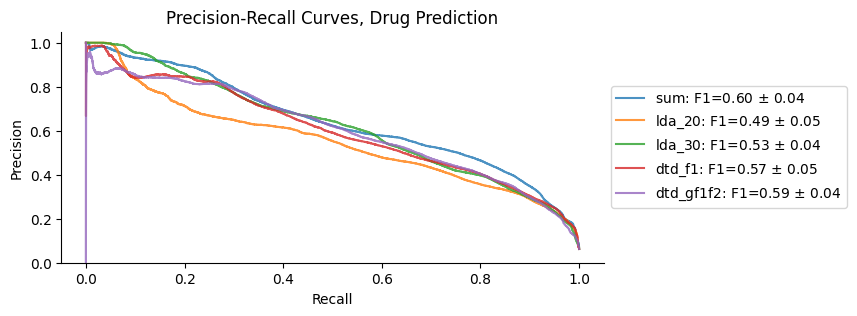

In [27]:
# one - vs -rest classification

plt.figure(figsize=(7,3))
ax = plt.gca()

for feature_type in feature_types:
    label = rf"{feature_type}: F1={onp.mean(f1s[feature_type]):.2f} $\pm$ {onp.std(f1s[feature_type])/onp.sqrt(n_labels):.2f}"
    ax.plot(recalls[feature_type], precisions[feature_type], label=label, alpha=0.8)

ax.set_title('Precision-Recall Curves, Drug Prediction')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim(0, 1.05)
ax.legend(loc='center left', bbox_to_anchor=[1,0.5])
sns.despine()

### Drug dose prediction

In [18]:
label_level = 'drug_names' # also valid: drug_class, drug_doses
feature_types = ['sum', 'lda_20', 'lda_30', 'dtd_f1', 'dtd_gf1f2']  # TO ADD: shuffled_moseq, lda, dtd

y = [f"{name}-{dose}" for name, dose in zip(metadata['session']['drug_names'], metadata['session']['drug_doses'])]

unique_labels = onp.unique(y)
n_labels = len(unique_labels)
label_binarizer = LabelBinarizer().fit(unique_labels)
y = label_binarizer.transform(y)
n_samples = 500 # for bootstrap measurements

In [19]:
precisions = OrderedDict(())
recalls = OrderedDict(())
f1s = OrderedDict(())

for feature_type in feature_types:
    print(f'Working on {feature_type}')

    x = data[feature_type]
        
    f1s[feature_type] = []
    all_true_labels = []
    all_scores = []
    
    for i_seed in trange(n_samples):
        # Using C=1 (strong reg) led to strong decline in F1 score
        # Using C=1e3 (lower reg) led to lbfgs failing to converge
        model, true_labels, pred_labels, scores = train_linear_classifier(x, y, test_size=0.10, seed=i_seed)  
        all_true_labels.append(model.label_binarizer_.transform(true_labels).toarray())  # For use with OneVRestClassifier
        all_scores.append(scores)
        
        per_label_f1 = f1_score(true_labels, pred_labels, average=None)
        f1s[feature_type].append(per_label_f1)
  
    precisions[feature_type], recalls[feature_type], _ = precision_recall_curve(
        onp.array(all_true_labels).ravel(), onp.array(all_scores).ravel()
    )
    f1s[feature_type] = onp.mean(f1s[feature_type], axis=0) # average over seeds

Working on lda_20


  0%|          | 0/500 [00:00<?, ?it/s]

Working on lda_30


  0%|          | 0/500 [00:00<?, ?it/s]

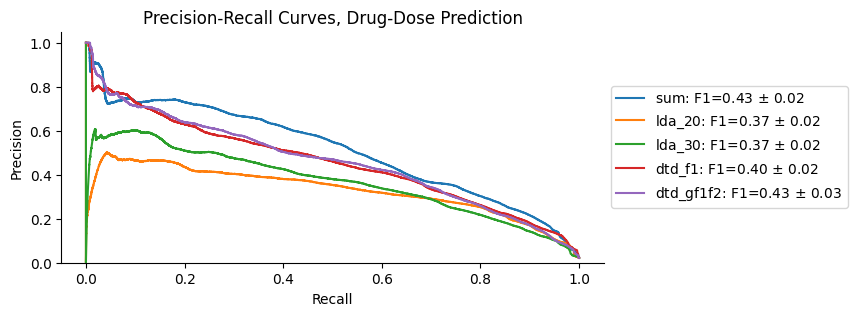

In [20]:
# one - vs -rest classification

plt.figure(figsize=(7,3))
ax = plt.gca()

for feature_type in feature_types:
    label = rf"{feature_type}: F1={onp.mean(f1s[feature_type]):.2f} $\pm$ {onp.std(f1s[feature_type])/onp.sqrt(n_labels):.2f}"
    ax.plot(recalls[feature_type], precisions[feature_type], label=label)

ax.set_title('Precision-Recall Curves, Drug-Dose Prediction')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim(0, 1.05)
ax.legend(loc='center left', bbox_to_anchor=[1,0.5])
# ax.legend()
sns.despine()